In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [11]:
con = sqlite3.connect('./dataset/database.sqlite')

In [12]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con)

In [13]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [14]:
filtered_data['Score']=filtered_data['Score'].map(partition)

In [15]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [16]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [17]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# BAG OF WORDS

In [19]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['Text'].values)
type(final_counts)
final_counts.get_shape()

(4986, 13510)

# Text Preprocessing

In [21]:
import re
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [25]:
stopwords = stopwords.words('english')

In [26]:
from tqdm import tqdm
preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:02<00:00, 1761.96it/s]


In [87]:
l = final['Score']

# Bi Grams

In [27]:
count_vect = CountVectorizer(ngram_range=(1,2))
final_bgram = count_vect.fit_transform(preprocessed_reviews)

In [88]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
model = tsne.fit_transform(final_bgram)
model = np.vstack((model.T,l)).T
df = pd.DataFrame(data=model, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

TypeError: A sparse matrix was passed, but dense data is required for method="barnes_hut". Use X.toarray() to convert to a dense numpy array if the array is small enough for it to fit in memory. Otherwise consider dimensionality reduction techniques (e.g. TruncatedSVD)

# TF-IDF

In [28]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tfidf = tfidf_vect.fit_transform(preprocessed_reviews)

In [89]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
model = tsne.fit_transform(final_tfidf)
model = np.vstack((model.T,l)).T
df = pd.DataFrame(data=model, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

TypeError: A sparse matrix was passed, but dense data is required for method="barnes_hut". Use X.toarray() to convert to a dense numpy array if the array is small enough for it to fit in memory. Otherwise consider dimensionality reduction techniques (e.g. TruncatedSVD)

# Word2Vec

In [29]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [31]:
is_your_ram_gt_16g=True
want_to_use_google_w2v = True
want_to_train_w2v = False

In [59]:
if want_to_train_w2v:
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.798933207988739), ('fantastic', 0.7935211658477783), ('tremendous', 0.7748855948448181), ('wonderful', 0.7647868394851685), ('good', 0.7291510105133057), ('incredible', 0.7032873630523682), ('marvelous', 0.6971103549003601), ('phenomenal', 0.6841564774513245), ('amazing', 0.6634128093719482), ('awesome', 0.6510506868362427)]
[('Worst', 0.6146091818809509), ('weakest', 0.6143776178359985), ('scariest', 0.5957258939743042), ('ugliest', 0.5931181311607361), ('best', 0.5835109949111938), ('bleakest', 0.5718506574630737), ('strongest', 0.5671455264091492), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631451606750488), ('toughest', 0.5624395608901978)]


In [65]:
w2v_words = list(w2v_model.wv.vocab)

In [68]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [06:31<00:00, 12.73it/s]

4986
300


In [85]:
from sklearn.manifold import TSNE
import seaborn as sn

In [93]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
model = tsne.fit_transform(sent_vectors)

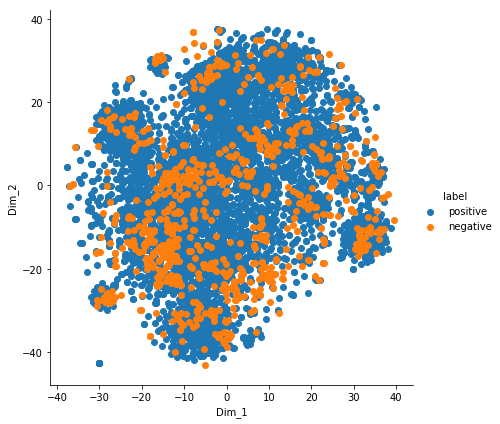

In [94]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

model = np.vstack((model.T,l)).T
df = pd.DataFrame(data=model, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()